In [21]:
# from data_cleaning import data_clean
# from feature_selection import get_feature_scores
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,  r2_score
from crawl_twitch import setup, get_oauth_token, save_streams_to_csv
from merge_runs import create_raw_csv
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow import keras
from data_cleaning import data_clean

If you like, you can create a twitch app in the API and grab some fresh data and concatenate entire dataset into twitch_streams_latest.csv:

In [133]:
client_id, client_secret = setup()
oauth_token = get_oauth_token(client_id, client_secret)
save_streams_to_csv("all", client_id, oauth_token)
create_raw_csv()

 Getting Twitch livestream snapshot (2025-06-09T19:37:16.426253)...


1265page  [02:55,  7.21page /s, streams=126158]


Finished. Fetched 126158 streams across 1265 pages.
Saved snapshot to C:\Users\Cyrus\Documents\school\Machine_Learning_SCU\Final Project\data\all-2025-06-09-12-37-16.csv
Merged CSV saved to C:\Users\Cyrus\Documents\school\Machine_Learning_SCU\Final Project\data\twitch_streams_latest.csv
Merged 14 snapshots, resulting in 885133 unique streams.


Functions for data cleaning, preprocessing and feature extraction/selection

In [136]:
#these functions are copied here from their individual files (i.e. data_clean.py). They are identical, and just here for your viewing convenience. 
def load_and_prepare_df(path):
    df = pd.read_csv(path)
    # Rename target column
    df.rename(columns={"viewer_count": "current_viewers"}, inplace=True)
    # Convert timestamps
    df["started_at"] = pd.to_datetime(df["started_at"], utc = True, errors = "coerce")
    df["snapshot_time"] = pd.to_datetime(df["snapshot_time"], utc = True, errors="coerce")
    # Remove "Special Events" and "Just Chatting"
    df = df[~df['game_name'].isin(["Special Events", "Just Chatting","Summer Game Fest"])]
    # Remove rows with bad timestamps or missing viewers
    df = df.dropna(subset=["current_viewers", "started_at", "snapshot_time"])
    # Feature engineering: duration in minutes
    df["duration_min"] = (
        df["snapshot_time"] - df["started_at"]
    ).dt.total_seconds() / 60
    # Only keep positive durations and viewer counts
    df = df[(df["duration_min"] > 0) & (df["current_viewers"] > 0)]
    # limit the number of games we look at because there's over 9000.
    top_games = df['game_name'].value_counts().nlargest(280).index
    df['game_name'] = df['game_name'].where(df['game_name'].isin(top_games), 'Other')
    #drop columns that we know won't can't be used in analysis  
    drop_cols = [
        "id",
        "game_id",
        "type",
        "title",
        "user_id",
        "user_login",
        "user_name",
        "thumbnail_url",
        "snapshot_time",
        "started_at",
    ]
    df = df.drop(columns=drop_cols)
    df['log_current_viewers'] = np.log1p(df['current_viewers']) #stdize these for regression models
    return df.reset_index(drop=True)

def remove_ingest_canary(df):
    """Remove rows where user_login starts with 'ingest_canary'."""
    if "user_login" in df.columns:
        mask = ~df["user_login"].str.startswith("ingest_canary", na=False)
        df = df[mask].reset_index(drop=True)
    return df

In [135]:
def get_feature_pipeline(df):
    # Identify features
    numeric_features = ["duration_min"]
    categorical_features = ["language", "game_name", "is_mature"]
    # Pipelines
    numeric_pipeline = Pipeline(
        [("imputer", SimpleImputer(strategy="mean")), 
        ("scaler", StandardScaler())]
    )
    categorical_pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline, numeric_features),
            ("cat", categorical_pipeline, categorical_features),
        ]
    )
    return preprocessor, numeric_features, categorical_features

In [51]:
def data_clean():
    df = load_and_prepare_df("data/twitch_streams_latest.csv")
    df = remove_ingest_canary(df)  # remove fake streams
    X = df.drop(columns=["current_viewers"])
    y = df["current_viewers"]
    # Split first (to avoid data leakage)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    # Build pipeline
    preprocessor, numeric_features, categorical_features = get_feature_pipeline(df)
    full_pipeline = Pipeline([("preprocessor", preprocessor)])

    # Fit transform X_train, only transform X_test
    X_train_pre = full_pipeline.fit_transform(X_train)
    X_test_pre = full_pipeline.transform(X_test)
    # For reference: get feature names after encoding
    cat_feature_names = (
        full_pipeline.named_steps["preprocessor"]
        .named_transformers_["cat"]
        .named_steps["onehot"]
        .get_feature_names_out(categorical_features)
    )
    feature_names = list(numeric_features) + list(cat_feature_names)
    print("Preprocessing complete. Shapes:")
    print("X_train_pre:", X_train_pre.shape)
    print("X_test_pre:", X_test_pre.shape)
    print("y_train:", y_train.shape)
    print("y_test:", y_test.shape)
    print("Feature names:", feature_names[:10], "...")
    return X_train_pre, X_test_pre, y_train, y_test, feature_names, full_pipeline,  X_train, X_test

In [52]:
def get_feature_scores(X, y, k = 10, threshold=1.0):
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X, y)
    feature_scores = pd.Series(selector.scores_, index=X.columns)
    sorted_scores = feature_scores.sort_values(ascending=False)
    if threshold is not None:
        sorted_scores = sorted_scores[sorted_scores > threshold]
    if k is not None:
        sorted_scores = sorted_scores[:k]
    return sorted_scores

In [27]:
X_train_pre, X_test_pre, y_train, y_test, feature_names, full_pipeline,  X_train, X_test = data_clean()
#for the regression models, will log-transform the output variable since it's extremely skewed
y_train_log = np.log1p(y_train)

Preprocessing complete. Shapes:
X_train_pre: (470198, 320)
X_test_pre: (117550, 320)
y_train: (470198,)
y_test: (117550,)
Feature names: ['duration_min', 'language_ar', 'language_asl', 'language_bg', 'language_ca', 'language_cs', 'language_da', 'language_de', 'language_el', 'language_en'] ...


After preprocessing, there's about 470k rows of data and 320 columns created as a result of one-hot encoding of the categorical variables. Both language and game type have a lot of values so those somewhat bloat the columns shown in the output. You can also see the 80-20 split chosen for training/testing. 

game_name_Counter-Strike          352.139260
duration_min                      226.841142
game_name_Path of Exile           161.950471
game_name_Mario Kart World        148.416541
game_name_League of Legends        89.368331
language_en                        81.203690
game_name_Dota 2                   54.324220
language_ru                        54.022805
game_name_Old School RuneScape     51.027414
game_name_Dune: Awakening          42.563273
dtype: float64


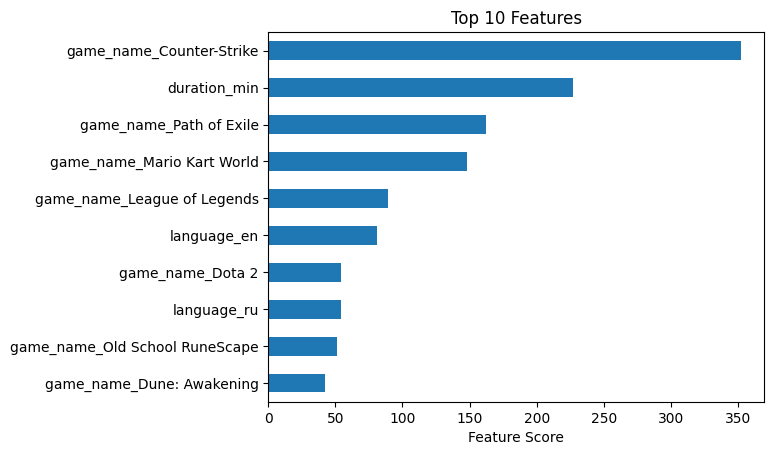

In [47]:
X_train_df = pd.DataFrame(X_train_pre.toarray(), columns=feature_names) #these are the selected down ones
X_test_df = pd.DataFrame(X_test_pre.toarray(), columns=feature_names)
feature_scores_linear_regression = get_feature_scores(X_train_df, y_train, k=10, threshold=2.0)
print(feature_scores_linear_regression)
feature_scores_linear_regression.sort_values(ascending=False).head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("Feature Score")
plt.title("Top 10 Features")
plt.show()

As we can see playing certain games, the duration, and language of the stream are extremely important factors in the model. 

In [30]:
selected_features = feature_scores_linear_regression.sort_values(ascending=False).index[:10]
X_train_selected = X_train_df[selected_features]
X_test_selected = X_test_df[selected_features]

We'll use the top 10 features to build a linear regression model and measure the error with Mean Absolute error since its less susceptible to outliers: 

In [31]:
lr = LinearRegression()
lr.fit(X_train_selected, y_train_log)
y_pred_log = lr.predict(X_test_selected)
y_pred = np.expm1(y_pred_log) #undo the log so we compare the raw values. 
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("R^2:", r2)
print("MAE:", mae)


R^2: -0.0009456423426894567
MAE: 18.76225352545229


As we can see, our MAE value is high, and our R^2 is close to 0, indicating that the model is very underfit and requires a more complex model. 

We'll try a random forest regression model next, this time using a grid search cv to consider different hyperparameter values for n_estimators and max_depth:

In [32]:
param_grid = {
    'regressor__n_estimators': [10, 20],
    'regressor__max_depth': [5, 10],
}

rf_model = Pipeline([
    ('preprocessing', full_pipeline), #preprocessing pipeline returned from data_clean()
    ('regressor', RandomForestRegressor())
])
# Fit the model
grid = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=4)
# Fit on log-transformed target, will use original dfs with all features (not just top k)
grid.fit(X_train, y_train_log)
y_pred_log = grid.predict(X_test)
y_pred = np.expm1(y_pred_log)
# Evaluate and print results
mae = mean_absolute_error(y_test, y_pred)
print("Best parameters:", grid.best_params_)
print("Random Forest MAE:", mae)

Best parameters: {'regressor__max_depth': 10, 'regressor__n_estimators': 20}
Random Forest MAE: 18.59625235471379


The best parameters for random forests in the grid search were a max depth of 10 and number of estimators at 20. 
The MAE of this model is 18.59, which is slightly less than that of the linear regression model, but still not that much better. 
Next, we'll try to use a simple neural network with 2 layers and relu activation function.

In [35]:

# Preprocess X_train, X_test with your pipeline, or use StandardScaler as needed
# X_train_pre = pipeline.fit_transform(X_train)
# X_test_pre = pipeline.transform(X_test_selected)

# Build a simple neural network model
model1 = keras.Sequential([
    keras.layers.Input(shape=(X_train_pre.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer for regression
])

model1.compile(optimizer='adam', loss='mae', metrics=['mae'])

# Fit model
history = model1.fit(X_train_pre, y_train_log, epochs=30, batch_size=64, validation_split=0.2)

# Predict and inverse-transform
y_pred_log = model1.predict(X_test_pre).flatten()
y_pred = np.expm1(y_pred_log)
print("MAE:", mean_absolute_error(y_test, y_pred))

Epoch 1/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.6027 - mae: 0.6027 - val_loss: 0.5737 - val_mae: 0.5737
Epoch 2/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.5679 - mae: 0.5679 - val_loss: 0.5722 - val_mae: 0.5722
Epoch 3/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.5662 - mae: 0.5662 - val_loss: 0.5703 - val_mae: 0.5703
Epoch 4/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.5620 - mae: 0.5620 - val_loss: 0.5687 - val_mae: 0.5687
Epoch 5/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.5617 - mae: 0.5617 - val_loss: 0.5680 - val_mae: 0.5680
Epoch 6/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.5591 - mae: 0.5591 - val_loss: 0.5684 - val_mae: 0.5684
Epoch 7/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.5584 - mae: 0.5584 - val_loss: 0.5678 - val_mae: 0.5678
Epoch 8/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.5565 - mae: 0.5565 - val_loss: 0.5678 - val_mae: 0.5678
Epoch 9/30
5878/5878 ━━━━━━━━━━━━━━━━━━━

##### The MAE for this model is 18.335, which is a decent improvement from the random forest model of 18.6.

Now we'll try a more complex model with one more layer and starting with a higher number of neurons, and also an sgd optimizer instead of adam

In [36]:
model2 = keras.Sequential([
    keras.layers.Input(shape=(X_train_pre.shape[1],)),
    keras.layers.Dense(128, activation='selu'),
    keras.layers.Dense(64, activation='selu'),
    keras.layers.Dense(32, activation='selu'),
    keras.layers.Dense(1)  # Output layer for regression
])
model2.compile(optimizer='sgd', loss='mae', metrics=['mae'])

# Fit model
history = model2.fit(X_train_pre, y_train_log, epochs=30, batch_size=64, validation_split=0.2)

# Predict and inverse-transform
y_pred_log = model2.predict(X_test_pre).flatten()
y_pred = np.expm1(y_pred_log)
print("MAE:", mean_absolute_error(y_test, y_pred))

Epoch 1/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.6075 - mae: 0.6075 - val_loss: 0.5900 - val_mae: 0.5900
Epoch 2/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.5821 - mae: 0.5821 - val_loss: 0.5899 - val_mae: 0.5899
Epoch 3/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.5795 - mae: 0.5795 - val_loss: 0.5798 - val_mae: 0.5798
Epoch 4/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.5800 - mae: 0.5800 - val_loss: 0.5815 - val_mae: 0.5815
Epoch 5/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.5782 - mae: 0.5782 - val_loss: 0.5850 - val_mae: 0.5850
Epoch 6/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.5773 - mae: 0.5773 - val_loss: 0.5782 - val_mae: 0.5782
Epoch 7/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.5762 - mae: 0.5762 - val_loss: 0.5767 - val_mae: 0.5767
Epoch 8/30
5878/5878 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.5751 - mae: 0.5751 - val_loss: 0.5763 - val_mae: 0.5763
Epoch 9/30
5878/5878 ━━━━━━━━━━━━━━━━━━━

This model has a MAE of 18.339, slightly worse than the simpler DNN. So I'll take 'model1' with the 2 layers as the 'best model'. Now we can use it to make a prediction. In this scenario I'll pretend that I'm an English-speaking mature streamer playing Counter Strike and plan to be streaming for 10 hours. How many viewers should I expect to have?

In [59]:
# Example: sample input as a dict (keys must match your features)
def predict_viewers(duration_hrs=10, lang="en", game="Counter Strike", is_mature=True):
    sample_dict = {
        "duration_min": 60 * duration_hrs, #convert hours to minutes
        "language": lang,
        "game_name": game,
        "is_mature": is_mature
    }
    
    sample_df = pd.DataFrame([sample_dict])
    # 2. Preprocess sample with pipeline
    sample_pre = full_pipeline.transform(sample_df)
    # 3. Predict with your Keras model
    pred_log = model1.predict(sample_pre).flatten()[0]
    pred = np.expm1(pred_log)  # If you trained on log1p(y)
    print("Predicted Number of Viewers:", pred)
    return pred
predict_viewers()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted Number of Viewers: 3.9347572


np.float32(3.9347572)

Seems like I'll get roughly 4 viewers despite all that hard work. :(. How does the number of viewers change depending on how long we stream for?

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predicted Number of Viewers: 1.478903
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Predicted Number of Viewers: 2.3369403
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Predicted Number of Viewers: 3.0630836
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Predicted Number of Viewers: 3.7001815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predicted Number of Viewers: 3.8594604
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Predicted Number of Viewers: 3.7910848
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Predicted Number of Viewers: 3.7606816
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Predicted Number of Viewers: 3.834536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Predicted Number of Viewers: 3.8034678
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Predicted Number of Viewers: 3.9347572
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Predicted Number of Viewers: 4.015371
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Predicted Number of Viewers: 3.925562
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Predicted Number of Viewers: 

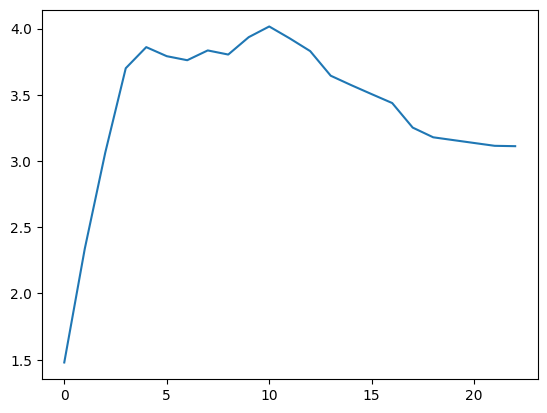

In [128]:
viewer_preds_stream_time = [predict_viewers(x) for x in range(1, 24)]
plt.plot(viewer_preds_stream_time)

What about language? If we stream in English, Spanish, Russian, German (de), Portugese(pt), or French, what's the effect?

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Predicted Number of Viewers: 3.9347572
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Predicted Number of Viewers: 2.9760983
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Predicted Number of Viewers: 3.6099205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Predicted Number of Viewers: 4.7045217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Predicted Number of Viewers: 7.1269293
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Predicted Number of Viewers: 5.4559236


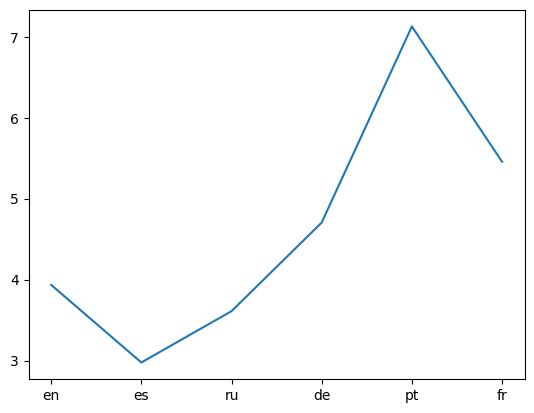

In [129]:
#X_train['language'].value_counts()
languages = ['en', 'es', 'ru', 'de', 'pt', 'fr']
viewer_preds_langs = [predict_viewers(lang=x) for x in languages]
plt.plot(viewer_preds_langs)
plt.xticks(list(range(len(languages))), languages) # Set tick locations and labels
plt.show()

Looks like Portugese is the way to go! It'll give us much more viewers than if we stream in English. This is probably because a significant amount of the Counter Strike player base (and active stream viewers) is in Brazil, where Portugese is the national language. 

What about if we make our stream more family friendly?

In [130]:
predict_viewers(is_mature=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Predicted Number of Viewers: 1.6857262


np.float32(1.6857262)

Nope, this actually severely decreases our viewer count! This is probably because people that watch Counter Strike enjoy more mature content, given that it is a mature game. 

Finally, what if we change the game? Let's try some very different games, Minecraft, ROBLOX, League of Legends, Madden NFL 25, Genshin Impact, Street Fighter 6, and Mario Kart World. 

In [131]:
games = ['Minecraft','ROBLOX', 'League of Legends', 'Madden NFL 25', 'Genshin Impact', 'Street Fighter 6', 'Mario Kart World']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Predicted Number of Viewers: 3.526476
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Predicted Number of Viewers: 1.8333786
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Predicted Number of Viewers: 3.691926
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Predicted Number of Viewers: 1.0357232
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Predicted Number of Viewers: 2.5713186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Predicted Number of Viewers: 3.558229
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Predicted Number of Viewers: 15.532322


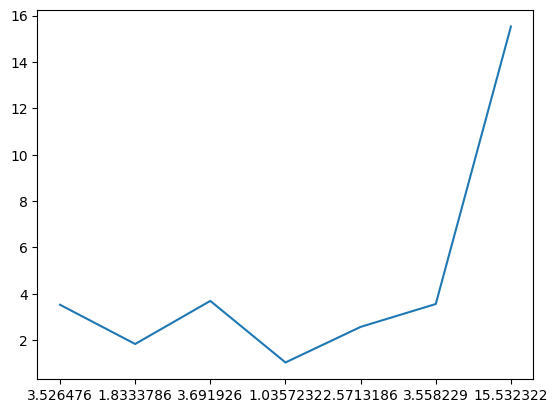

[0, 1, 2, 3, 4, 5, 6]

In [132]:
viewer_preds_games = [predict_viewers(game=x) for x in games]
plt.plot(viewer_preds_games)
plt.xticks([0,1,2,3,4,5,6], viewer_preds_games) # Set tick locations and labels
plt.show()
list(range(len(viewer_preds_games)))

Clearly, we need to switch games to Mario Kart! We'll get 15 viewers then.

So overall, we can either switch to streaming Mario Kart, or stream in Portugese to maximize our viewer count. 